In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


In [6]:
# define cleaning functions
def clean_q_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe, series, series
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    
    # annual peak Q
    annual_peak_q = q_df.groupby(q_df.year)['cfs'].max()

#     # cumulative Q
#     sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()
#     sum_q_df = pd.DataFrame(q_df.year,sum_q).reset_index()
#     annual_sum_q = sum_q_df.groupby(sum_q_df.year)['cfs'].max()

    return(daily_q_df, annual_peak_q)

def clean_snow_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    snow_df = dataframe
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['dt_string'])
    snow_df['year'] = snow_df['dt'].dt.year
    snow_df['month'] = snow_df['dt'].dt.month
    
    # drop datetime string column
    snow_df.drop(['dt_string'], axis=1, inplace=True)

    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)
    
    # remove september data (highly volatile and uncharacteristic)
    snow_df.drop(snow_df[snow_df.month == 9].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    
    # clean airtemp outliers
    snow_df = remove_outliers(snow_df)
    
    # annual peak swe
    annual_peak_swe = snow_df.groupby(snow_df.year)['swe_start_m'].max()
    
    # annual cumulative swe
    cumsum_swe = snow_df.groupby(snow_df['year'])['swe_start_m'].cumsum()
    
    # monthly cumulative swe
    swe_monthly = snow_df.groupby([snow_df['year'], snow_df['month']])['swe_start_m'].cumsum()
    
    return(snow_df, annual_peak_swe, cumsum_swe, swe_monthly)

def remove_outliers(df):
    ''' 
    input: dataframe of snotel data with columns re-named for degrees C
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [7]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df, annual_peak_q = clean_q_data_annual(q_df)

# annual sum q
#annual_cumsum_q = daily_q_df.groupby(daily_q_df.index.year)['cfs'].cumsum()
#annual_sum_q = annual_cumsum_q.groupby(annual_cumsum_q.index.year).max()

In [8]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass',
                '682_park_reservoir','669_north_lost_trail','1059_cochetopa_pass','618_mcclure_pass',
                '409_columbine_pass','675_overland_reservoir','622_mesa_lakes','538_idarado',
               '713_red_mtn_pass']

# make data column names
cols_data = []
for station in stationnames:
    sum_list = '{}_sumswe'.format(station[:3])
    cols_data.append(sum_list)
    peak_list = '{}_peakswe'.format(station[:3])
    cols_data.append(peak_list)
cols_data.append('peak_q')
cols_data.append('sum_q')

# merge snotel data with q data
data_lst = []
count = 0
#peakswe_lst = []
#sumswe_lst = []
#monthly_lst = []
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['dt_string', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    
    snow_df['stn'] = stationname
    
    # import cleaned snow data
    snow_df, annual_peak_swe, cumsum_swe, swe_monthly = clean_snow_data_annual(snow_df)

    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    #peakswe_lst.append(annual_peak_swe)
    #sumswe_lst.append(cumsum_swe)
    #monthly_lst.append(swe_monthly)
    count += 1
print(count)

# contatenate data
data_df = pd.concat(data_lst, axis=0, ignore_index = True)

# set index as datetime
data_df.set_index('dt', inplace=True);



13


## calculate cumulative monthly swe and q

In [9]:
# cumulative monthly swe
swe_cumsum = data_df.groupby(['year','month'])['swe_start_m'].cumsum()
data_df['swe_cumsum'] = swe_cumsum

# cumulative monthly cfs
cfs_cumsum = data_df.groupby(['year','month'])['cfs'].cumsum()
data_df['cfs_cumsum'] = cfs_cumsum



In [10]:
# get dummies for station names 
data_all = pd.get_dummies(data_df)



### remove features based on iterative model assessments

In [11]:
# drop cfs column
#data_all.drop('cfs', axis=1, inplace=True)
data_all.drop('cfs_cumsum', axis=1, inplace=True)
# drop month, year
data_all.drop('year', axis=1, inplace=True)
data_all.drop('month', axis=1, inplace=True)
#data_all.drop('airtemp_max_C', axis=1, inplace=True)
#data_all.drop('airtemp_mean_C', axis=1, inplace=True)
#data_all.drop('precip_incr_m', axis=1, inplace=True)

In [29]:
data_all.tail()

,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,cfs,swe_cumsum,stn_1059_cochetopa_pass,stn_409_columbine_pass,...,stn_618_mcclure_pass,stn_622_mesa_lakes,stn_669_north_lost_trail,stn_675_overland_reservoir,stn_680_park_cone,stn_682_park_reservoir,stn_701_porphyry_creek,stn_713_red_mtn_pass,stn_737_schofield_pass,stn_762_slumgullion
dt,,,,,,,,,,,,,,,,,,,,,
2018-03-11,0.31242,6.666667,-7.222222,-2.222222,0.31750,NaN,920.728261,36.80206,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-03-12,0.30988,6.111111,-7.777778,-1.666667,0.31496,0.00254,919.541667,37.11194,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-03-13,0.31496,7.777778,-9.444444,-1.666667,0.31750,0.00000,913.981481,37.42690,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-03-14,0.31242,9.444444,-5.000000,1.111111,0.31750,0.00000,NaN,37.73932,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-03-15,0.30988,NaN,NaN,NaN,0.31750,NaN,NaN,38.04920,0,0,...,0,0,0,0,0,0,0,1,0,0


## pipeline: standardize and linear regression

### prep data for modeling

In [43]:
# drop nans
data_clean = data_all.dropna()

# define dataframe and columns
model_df = data_clean
cols = model_df.columns

# split train and test data
split_year = 2015

train_df = model_df[model_df.index.year < split_year]
test_df = model_df[model_df.index.year >= split_year]

target_col = 'cfs'
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]

X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

# define pipeline
alpha = 559
pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('regression', Ridge(alpha)),
])

# predict train
pipeline.fit(X_train,y_train)
y_hat_train = pipeline.predict(X_train)
# # Now evaluate all steps on test set
y_hat_test = pipeline.predict(X_test)





In [52]:
# regression scores and coefficients
# R2 score
score = pipeline.score(X_test,y_test)
print('R2 = {0:.3f}'.format(score))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('RMSE = {0:.3f}'.format(rmse))

# coefficients
model = pipeline.named_steps['regression']
coefs = model.coef_
print(coefs)


R2 = 0.387
RMSE = 1083.791
[-628.92761718   28.29378249  216.3266762   -48.3230776  1553.90037995
   -8.00195773  -39.51166056   66.93484611 -118.77578203  -18.43379883
  -45.94674783  -18.83019134  -75.10987566   36.31353109  149.96659969
  -66.37440934  160.57223673  -71.38138543 -134.26488614  162.20158411]


In [51]:
rmse

1083.7906264408175

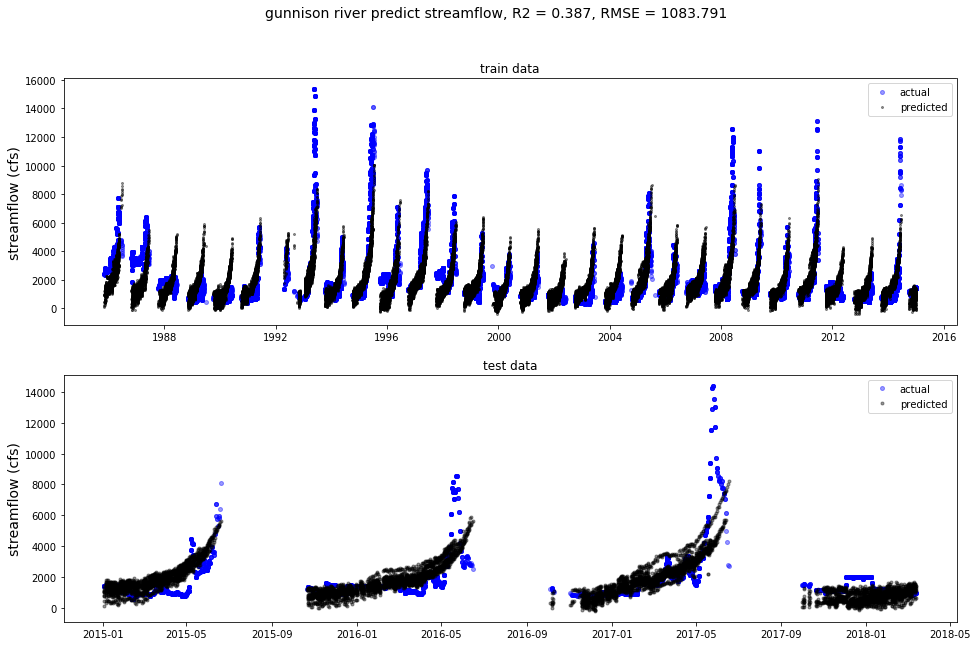

In [53]:
df = model_df # dataframe to plot from
figname = 'gunnison river predict streamflow'

# plot
fig, ax = plt.subplots(2,1,figsize=(16,8));
ax[0].plot(y_train.index,y_train.values,'bo', markersize=4, alpha=0.4)
ax[0].set_ylabel('streamflow (cfs)', fontsize=14);
#ax[0].set_xlabel('year', fontsize=14)
ax[0].plot(y_train.index,y_hat_train,'ko', markersize=2, alpha=0.4)
ax[0].legend(['actual','predicted'])
ax[0].set_title('train data')

ax[1].plot(y_test.index,y_test.values,'bo', markersize=4, alpha=0.4)
ax[1].set_ylabel('streamflow (cfs)', fontsize=14);
#ax[1].set_xlabel('year', fontsize=14)
ax[1].plot(X_test.index,y_hat_test,'ko', markersize=3, alpha=0.4)
ax[1].legend(['actual','predicted'])
ax[1].set_title('test data')
plt.suptitle('{}, R2 = {}, RMSE = {}'.format(figname,str(round(score,3)), str(round(rmse,3))),fontsize=14)

# save fig
fig.set_size_inches(16, 10)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)

In [46]:
#coefficient matrix
D = {}
for idx, name in enumerate(X_train.columns):
    D[name] = coefs[idx]
print(D)

import csv
#write to file:
with open('gunnison_coefs_q_allstations_bestalpha.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for k, v in D.items():
       writer.writerow([k,v])

{'swe_start_m': -628.9276171832544, 'airtemp_max_C': 28.293782490854056, 'airtemp_min_C': 216.32667620384066, 'airtemp_mean_C': -48.32307760336976, 'precip_start_m': 1553.9003799473974, 'precip_incr_m': -8.001957729473943, 'swe_cumsum': -39.511660560256516, 'stn_1059_cochetopa_pass': 66.9348461050622, 'stn_409_columbine_pass': -118.77578203220367, 'stn_538_idarado': -18.433798829737416, 'stn_618_mcclure_pass': -45.946747828332185, 'stn_622_mesa_lakes': -18.83019134340874, 'stn_669_north_lost_trail': -75.10987565832275, 'stn_675_overland_reservoir': 36.31353109363633, 'stn_680_park_cone': 149.96659968728443, 'stn_682_park_reservoir': -66.37440933904966, 'stn_701_porphyry_creek': 160.5722367277578, 'stn_713_red_mtn_pass': -71.38138543183264, 'stn_737_schofield_pass': -134.26488614412813, 'stn_762_slumgullion': 162.20158410825135}


In [34]:
def cross_val(X, y, model, n_folds, errortype='RMSE', random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
    
    Requirements
    ----------
    class XyScaler
    function rmsle
 
    Parameters
    ----------
 
    X: np.array
      Matrix of predictors, standardized
 
    y: np.array
      Target array, standardized
 
    model: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
 
    n_folds: int
      The number of folds in the cross validation.
    
    errortype: string
      either 'RMSE' or 'RMSLE'
 
    random_seed: int
      A seed for the random number generator, for repeatability.
 
    Returns
    -------
 
    errors, cfs_best: tuple of arrays
    errors = (train errors, test errors) for each fold of cross-validation
    cfs-best = coefficients selected from minimum test error
    """
    # choose KFolds or TimeSeriesSplit
    kf = TimeSeriesSplit(n_splits=n_folds)
    #kf = KFold(n_folds, random_state=random_seed)
    errorlist = []
    cfs = []
    for k, (train_index,test_index) in enumerate(kf.split(X)):
        # define variables
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        # fit model
        model.fit(X_train,y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test) 
        # evaluate model
        if errortype == 'RMSE':
            rmse_train = np.sqrt(mean_squared_error(y_hat_train,y_train))
            rmse_test = np.sqrt(mean_squared_error(y_hat_test,y_test))
            errorlist.append((rmse_train, rmse_test)) # tuple output
        elif errortype == 'RMSLE':
            rmsle_train = rmsle(y_train, y_hat_train)
            rmsle_test = rmsle(y_test, y_hat_test)
            errorlist.append((rmsle_train, rmsle_test)) # tuple output
        # store coefficients
        cfs.append (model.coef_)
    # select best coefficients 
    errors = np.asarray(errorlist)
    idx_min_test_error = errors[:,1].argmin()   
    cfs_best = cfs[idx_min_test_error]
    
    return(errors, cfs_best)

In [35]:
def train_at_various_alphas(X, y, model, alphas, n_folds=10, errortype='RMSE', **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
    
    requirements
    ----------
    class XyScaler
    function rmsle
    function cross_val

    Parameters
    ----------
 
    X: np.array
      Matrix of predictors, standardized
 
    y: np.array
      Target array, standardized
 
    model: name of sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are 'Ridge' and 'Lasso'.
 
    alphas: numpy array
      An array of regularization parameters.
 
    n_folds: int
      Number of cross validation folds.
    
    errortype: string
      either 'RMSE' or 'RMSLE'
 
    Returns
    -------
 
    cv_errors_train, cv_errors_test: tuple of DataFrame
      DataFrames containing the training and testing errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
      
      Dataframe containing coefficients for each parameter for each alpha
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    coefs_df = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for idx, alpha in enumerate(alphas):
        errors, coefs = cross_val(X, y, model(alpha), n_folds, errortype='RMSE', random_seed=154)
        cv_errors_train.iloc[:,idx] = errors[:,0]
        cv_errors_test.iloc[:,idx] = errors[:,1]
        #coefs_df.iloc[:,idx] = coefs
    return(cv_errors_train, cv_errors_test)#, coefs_df

In [4]:
standardizer = StandardScaler()
standardizer.fit(X_train,y_train)
xx = standardizer.transform(X_train)


NameError: name 'X_train' is not defined

In [37]:
type(xx)

numpy.ndarray

In [1]:


# run a cross validation
X = xx
y = np.array(y_train)

#
alpha= 330
model = Ridge(alpha)
n_folds = 5
errors, cfs_best = cross_val(X, y, model, n_folds, errortype='RMSE', random_seed=154)

NameError: name 'xx' is not defined

In [39]:
# run an alpha test
X = xx
y = np.array(y_train)

model = Ridge # must be 'Ridge' or 'Lasso'
# define alphas
alphas = np.logspace(-2,8,100)
n_folds=30
errortype='RMSE'
cv_errors_train, cv_errors_test = train_at_various_alphas(X, y, model, alphas, n_folds, errortype)

min error = 1325.8414091617344
alpha at min error = 559.0810182512223


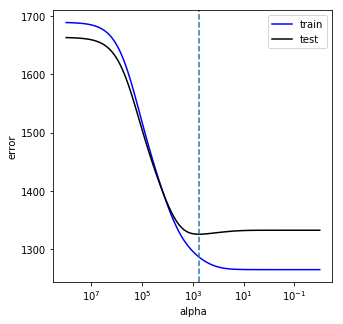

In [42]:
# outputs from alpha testing
train_means = cv_errors_train.mean(axis=0)
test_means = cv_errors_test.mean(axis=0)
# calc min alpha
min_idx = test_means.values.argmin()
min_alpha = alphas[min_idx]
print('min error = {}'.format(np.min(test_means)))
print('alpha at min error = {}'.format(min_alpha))

fig, axs = plt.subplots(1,1,figsize=(5,5));
h1 = axs.plot(alphas,train_means,'b-')
h2 = axs.plot(alphas,test_means,'k-')
axs.set_xscale('log')
axs.invert_xaxis()
axs.set_xlabel('alpha')
axs.set_ylabel('error')
plt.axvline(min_alpha, linestyle='dashed')
plt.legend(('train','test'));
#axs.set_yscale('log');

# save fig
figname = 'alpha_test_no_september'
fig.set_size_inches(5, 5)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)

In [60]:
np.shape(X)

(58904, 20)

In [66]:
np.shape(y)

(58904,)

In [107]:
X_train.columns

Index(['swe_start_m', 'airtemp_max_C', 'airtemp_min_C', 'airtemp_mean_C',
       'precip_start_m', 'precip_incr_m', 'year', 'month', 'cfs',
       'stn_1059_cochetopa_pass', 'stn_409_columbine_pass',
       'stn_618_mcclure_pass', 'stn_622_mesa_lakes',
       'stn_669_north_lost_trail', 'stn_675_overland_reservoir',
       'stn_680_park_cone', 'stn_682_park_reservoir', 'stn_701_porphyry_creek',
       'stn_737_schofield_pass', 'stn_762_slumgullion'],
      dtype='object')